# Dog-breed classification by Levi Feldman

In this project I will be exploring the deep-learning approach to writing an algorithm that can correctly classify an image of a dog to it's breed. Furthermore, given an image of a human, the algorithm should be able to output the breed that the image most resembles. 

This project will focus on CNN's, Convolutional Neural Networks, to accomplish the task of dog breed clasification. To read more about CNN's: http://cs231n.github.io/convolutional-networks/

This project will also use transfer learning to accomplish the classification. Transfer learning is a deep-learning technique that basically uses a model with pretrained weights for a similar task than the one at hand and thereby needing a lot less computing power to adjust the weights to the specific task at hand. 

As you can see below, there are 133 different possible breeds for classification. We have 8351 total dog images split into training, testing, and validation sets. We also have 13233 human images.

First we will build a human/dog detector in order to first determine if the image is one of a human, or one of a dog. Next we will build the classifier with transfer learning. Finally we will put the two together to create the final algorithm.

The task of assigning breed to dogs from images is considered exceptionally challenging. Even a human would have a hard time distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, labradors come in yellow, chocolate, and black. This algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Also, setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%. So even an accuracy of 1% is still better than random chance.  


In [7]:
### LOAD DOG IMAGES ###


from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# creating list of dog names 
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [9]:
dog_names

['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_cho

In [22]:
### LOAD HUMAN IMAGES ###

import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


# Human/Dog detector

To do this with the highest accuracy, we will use the weights of a ResNet50 model pretrained on imagenet. This pretrained model actually has 1000 different classification catagories so we will load the model without the last couple layers with a convenient function('include_top=False'), and train a few dense layers after it using bottleneck features from the resnet50 model as input. I trained the dense layers with 6500 human images and 6500 dog images, totalling 13000 images. labels were binary with a sigmoid activation 1 for human, 0 for dog.

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

### THESE FUNCTIONS TAKE IMAGE PATHS AS INPUT AND RETURNS 4 DIMENSIONAL NUMPY ARRAYS OF THE PIXEL DATA ###

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
### CREATING RESNET50 MODEL WITHOUT THE LAST LAYERS FOR BOTTLENECK NETWORK ####


from keras.applications.resnet50 import ResNet50


dh_btlnck = ResNet50(include_top=False, weights='imagenet')
dh_btlnck.summary()

94658560/94653016 [==============================] - 17s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________

In [21]:
### FUNCTION TO EXTRACT OUTPUT OF RESNET50 MODEL('include_top=False') GIVEN AN IMAGE ###

from keras.applications.resnet50 import preprocess_input, decode_predictions

def dh_part1(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return dh_btlnck.predict(img)

In [14]:
dh_part1(human_files[0]).shape

(1, 1, 1, 2048)

In [15]:
### processing data to train human/dog detector #####


### TAKING SOME HUMAN AND DOG FILES FOR TRAINING ###
some_human_files = human_files[:6500]
some_dog_files = train_files[:6501]
some_dog_files = np.delete(some_dog_files, 1859) ## bad file
print("# of training;  dog images: " + str(len(some_dog_files)) + ",    human images: " + str(len(some_human_files)))

### CREATING LIST OF INPUT FEATURES TO THE DH_PART2 NETWORK(THE LAST NEW DENSE LAYERS WE WILL BE ADDING) ###
### BY TAKING OUTPUT OF IMAGES PUT THROUGH THE RESNET50'include_top=False') MODEL ###
btlnck = []
for i in range(6500):
    print(i)
    btlnck.append(dh_part1(some_human_files[i]))
    btlnck.append(dh_part1(some_dog_files[i]))
    
btlnck = np.vstack(btlnck)
print(len(btlnck))


labels = [] ### 0 for 'Dog', 1 for 'Human'
for i in range(6500):
    labels.append(1)
    labels.append(0)
print(len(labels), labels)
    

# of training;  dog images: 6500,    human images: 6500
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
26

1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049


3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688


5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327


In [16]:
### CREATING NEW LAST LAYERS ### 


from keras.models import Sequential
from keras.layers import Dense, Flatten
dh_part2 = Sequential()
dh_part2.add(Flatten(input_shape=(1,1,2048)))
dh_part2.add(Dense(500, activation='relu'))
dh_part2.add(Dense(20, activation='sigmoid'))
dh_part2.add(Dense(1, activation='sigmoid'))
dh_part2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1024500   
_________________________________________________________________
dense_2 (Dense)              (None, 20)                10020     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,034,541
Trainable params: 1,034,541
Non-trainable params: 0
_________________________________________________________________


In [17]:
dh_part2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
### TRAINING LAST LAYERS WITH BOTTLENECK FEATURES ###

from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='dh_part2.weights.best.hdf5', verbose=1)
dh_part2.fit(btlnck, labels, epochs=25, 
          callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/50
13000/13000 [==============================] - 12s 903us/step - loss: 0.0182 - acc: 0.9989

Epoch 00001: saving model to dh_part2.weights.best.hdf5
Epoch 2/50
13000/13000 [==============================] - 11s 864us/step - loss: 5.1865e-04 - acc: 1.0000

Epoch 00002: saving model to dh_part2.weights.best.hdf5
Epoch 3/50
13000/13000 [==============================] - 11s 835us/step - loss: 1.4024e-05 - acc: 1.0000

Epoch 00003: saving model to dh_part2.weights.best.hdf5
Epoch 4/50
13000/13000 [==============================] - 13s 979us/step - loss: 4.8249e-07 - acc: 1.00001s - loss: 5.4237e - ETA: 0s - loss: 5.1205

Epoch 00004: saving model to dh_part2.weights.best.hdf5
Epoch 5/50
13000/13000 [==============================] - 11s 847us/step - loss: 1.1072e-07 - acc: 1.0000

Epoch 00005: saving model to dh_part2.weights.best.hdf5
Epoch 6/50
13000/13000 [==============================] - 12s 913us/step - loss: 1.0960e-07 - acc: 1.0000

Epoch 00006: saving model to dh_part2.w

KeyboardInterrupt: 

In [19]:
dh_part2.load_weights('dh_part2.weights.best.hdf5')

def human_dog_detector(img_path):
    Q = dh_part1(img_path)
    if dh_part2.predict(Q) - 0.5 > 0:
        return True
    else: 
        return False

In [22]:
## TESTING ###

human_files_short = human_files[-1000:]
dog_files_short = valid_files[-500:]
dog_files_short = np.append(dog_files_short, test_files[-500:])
print(len(human_files_short), len(dog_files_short))

faces_in_human_files = []
faces_in_dog_files = []
for i in range(1000):
    
    if human_dog_detector(human_files_short[i]) == True:
        faces_in_human_files.append(1)
    else:
        faces_in_human_files.append(0)
    
    if human_dog_detector(dog_files_short[i]) == True:
        faces_in_dog_files.append(1)
    else:
        faces_in_dog_files.append(0)
        
        
print('{}% of the faces in "human_files_short" were detected by our algorithm'.format(1000*np.mean(faces_in_human_files)))
        
print('Our algorithm determined that {}% of the images in "dog_files_short" have a human face in them'.format(1000*np.mean(faces_in_dog_files)))
        


1000 1000
1000.0% of the faces in "human_files_short" were detected by our algorithm
Our algorithm determined that 0.0% of the images in "dog_files_short" have a human face in them


So as you can see this algorithm correctly differentiates between humans and dogs 1000% of the time.

In [24]:
dh_btlnck.save('dh_btlnck.hdf5')
dh_part2.save('dh_part2.hdf5')

In [5]:
#### CREATE FINAL HUMAN/DOG DETECTOR FUNCTION ###
import numpy as np
from keras.models import load_model

dh1 = load_model('dh_btlnck.hdf5')
dh2 = load_model('dh_part2.hdf5')


from keras.applications.resnet50 import preprocess_input
def human_dog_detector(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    Q = dh1.predict(img)
    if dh2.predict(Q) - 0.5 > 0:
        return 'Human'
    else: 
        return 'Dog'

/home/lion/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
### FUNCTION TO DISPLAY IMAGES ###

def display(path):
    img = cv2.imread(path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

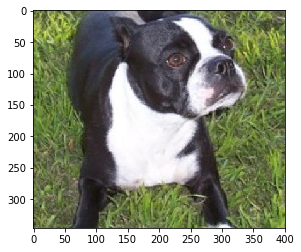

Dog


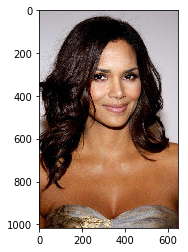

Human


In [12]:
### Test any image ###
import matplotlib.pyplot as plt                        
import cv2
%matplotlib inline                               


display('testdog.jpg')
print(human_dog_detector('testdog.jpg'))


display('testhuman.jpg')
print(human_dog_detector('testhuman.jpg'))

# Dog-breed Classifier

Here is where I will build the breed classifier using transfer learning. I have obtained the bottleneck_features by putting the dog images through a resnet50 without the top model pretrained on imagenet. The bottleneck features are saved in the folder bottleneck_features/. After extracting them I will train a new network with a couple of dense layers and a softmax output for all of the different breeds.  

The problem at hand here is that we have already a resnet network output of 2048 convolutional filters. now we need a network to take those listed 2048 features(eyebrow size, mouth shape ...etc) and classify them according to breed. I chose a 512 relu layer for the first hidden layer to break down the list of features, followed by a 256 layer of sigmoids to really draw the line between breeds. 

In [51]:
### EXTRACTING BOTTLNECK FEATURES OF DOG IMAGES PUT THROUGH RESNET50 MODEL ### 
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

print(train_Resnet50.shape)

(6680, 1, 1, 2048)


In [52]:
### DEFINING THE NETWORK ARCHITECTURE ###

dn = Sequential()
dn.add(Flatten(input_shape=(1,1,2048)))
dn.add(Dense(512, activation='relu'))
dn.add(Dense(256, activation='sigmoid'))
dn.add(Dense(133, activation='softmax'))
dn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 133)               34181     
Total params: 1,214,597
Trainable params: 1,214,597
Non-trainable params: 0
_________________________________________________________________


In [53]:
dn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [54]:
### TRAINING ###

my_checkpointer = ModelCheckpoint(filepath='saved_models/transfer_learned.hdf5', 
                               verbose=1, save_best_only=True)

dn.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[my_checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 13s 2ms/step - loss: 2.3049 - acc: 0.5046 - val_loss: 1.0725 - val_acc: 0.6970

Epoch 00001: val_loss improved from inf to 1.07246, saving model to saved_models/transfer_learned.hdf5
Epoch 2/20
6680/6680 [==============================] - 12s 2ms/step - loss: 0.7181 - acc: 0.8069 - val_loss: 0.7776 - val_acc: 0.7617

Epoch 00002: val_loss improved from 1.07246 to 0.77764, saving model to saved_models/transfer_learned.hdf5
Epoch 3/20
6680/6680 [==============================] - 11s 2ms/step - loss: 0.4304 - acc: 0.8711 - val_loss: 0.6406 - val_acc: 0.7952

Epoch 00003: val_loss improved from 0.77764 to 0.64057, saving model to saved_models/transfer_learned.hdf5
Epoch 4/20
6680/6680 [==============================] - 13s 2ms/step - loss: 0.2862 - acc: 0.9139 - val_loss: 0.6445 - val_acc: 0.8048

Epoch 00004: val_loss did not improve
Epoch 5/20
6680/6680 [==============================] 

In [55]:
dn.load_weights('saved_models/transfer_learned.hdf5')

In [56]:
dn.save('saved_models/breed_detector.hdf5')

In [57]:
### TESTING THE MODEL ###

dn = load_model('saved_models/breed_detector.hdf5')

transfer_learned_predictions = [np.argmax(dn.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(transfer_learned_predictions)==np.argmax(test_targets, axis=1))/len(transfer_learned_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.0239%


# Writing the final algorithm

Now we have the final algorithm all you have to do to try it out for yourself is make sure you run the next two code blocks after this and then simply type: 

Dog_project(path_to_image) 

In [10]:
from keras.models import load_model
import cv2                
import matplotlib.pyplot as plt   
%matplotlib inline                               

dog_names = ['Affenpinscher',
 'Afghan_hound',
 'Airedale_terrier',
 'Akita',
 'Alaskan_malamute',
 'American_eskimo_dog',
 'American_foxhound',
 'American_staffordshire_terrier',
 'American_water_spaniel',
 'Anatolian_shepherd_dog',
 'Australian_cattle_dog',
 'Australian_shepherd',
 'Australian_terrier',
 'Basenji',
 'Basset_hound',
 'Beagle',
 'Bearded_collie',
 'Beauceron',
 'Bedlington_terrier',
 'Belgian_malinois',
 'Belgian_sheepdog',
 'Belgian_tervuren',
 'Bernese_mountain_dog',
 'Bichon_frise',
 'Black_and_tan_coonhound',
 'Black_russian_terrier',
 'Bloodhound',
 'Bluetick_coonhound',
 'Border_collie',
 'Border_terrier',
 'Borzoi',
 'Boston_terrier',
 'Bouvier_des_flandres',
 'Boxer',
 'Boykin_spaniel',
 'Briard',
 'Brittany',
 'Brussels_griffon',
 'Bull_terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn_terrier',
 'Canaan_dog',
 'Cane_corso',
 'Cardigan_welsh_corgi',
 'Cavalier_king_charles_spaniel',
 'Chesapeake_bay_retriever',
 'Chihuahua',
 'Chinese_crested',
 'Chinese_shar-pei',
 'Chow_chow',
 'Clumber_spaniel',
 'Cocker_spaniel',
 'Collie',
 'Curly-coated_retriever',
 'Dachshund',
 'Dalmatian',
 'Dandie_dinmont_terrier',
 'Doberman_pinscher',
 'Dogue_de_bordeaux',
 'English_cocker_spaniel',
 'English_setter',
 'English_springer_spaniel',
 'English_toy_spaniel',
 'Entlebucher_mountain_dog',
 'Field_spaniel',
 'Finnish_spitz',
 'Flat-coated_retriever',
 'French_bulldog',
 'German_pinscher',
 'German_shepherd_dog',
 'German_shorthaired_pointer',
 'German_wirehaired_pointer',
 'Giant_schnauzer',
 'Glen_of_imaal_terrier',
 'Golden_retriever',
 'Gordon_setter',
 'Great_dane',
 'Great_pyrenees',
 'Greater_swiss_mountain_dog',
 'Greyhound',
 'Havanese',
 'Ibizan_hound',
 'Icelandic_sheepdog',
 'Irish_red_and_white_setter',
 'Irish_setter',
 'Irish_terrier',
 'Irish_water_spaniel',
 'Irish_wolfhound',
 'Italian_greyhound',
 'Japanese_chin',
 'Keeshond',
 'Kerry_blue_terrier',
 'Komondor',
 'Kuvasz',
 'Labrador_retriever',
 'Lakeland_terrier',
 'Leonberger',
 'Lhasa_apso',
 'Lowchen',
 'Maltese',
 'Manchester_terrier',
 'Mastiff',
 'Miniature_schnauzer',
 'Neapolitan_mastiff',
 'Newfoundland',
 'Norfolk_terrier',
 'Norwegian_buhund',
 'Norwegian_elkhound',
 'Norwegian_lundehund',
 'Norwich_terrier',
 'Nova_scotia_duck_tolling_retriever',
 'Old_english_sheepdog',
 'Otterhound',
 'Papillon',
 'Parson_russell_terrier',
 'Pekingese',
 'Pembroke_welsh_corgi',
 'Petit_basset_griffon_vendeen',
 'Pharaoh_hound',
 'Plott',
 'Pointer',
 'Pomeranian',
 'Poodle',
 'Portuguese_water_dog',
 'Saint_bernard',
 'Silky_terrier',
 'Smooth_fox_terrier',
 'Tibetan_mastiff',
 'Welsh_springer_spaniel',
 'Wirehaired_pointing_griffon',
 'Xoloitzcuintli',
 'Yorkshire_terrier']


def extract_Resnet50(tensor):
    from keras.applications.resnet50 import ResNet50, preprocess_input
    return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

d2 = load_model('dh_part2.hdf5')
breed_detector = load_model('saved_models/breed_detector.hdf5')

In [11]:
import numpy as np

def Dog_project(path):
    d1 = extract_Resnet50(path_to_tensor(path))
    dog_or_human = d2.predict(d1)
    
    out = breed_detector.predict(d1)
    breed = dog_names[np.argmax(out)]
    
    if 0.6 > dog_or_human > 0.4:
        print('Error: no dog or human detected')
    elif dog_or_human - 0.5 > 0:
        print('Hello fellow, your features have the most in common with the {} dog breed.'.format(breed))
    else:
        print('Sup doggg, I know who you are. You are a .....{}'.format(breed))
                      
    img = cv2.imread(path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(cv_rgb)
    plt.show()
    return 'cool!'

Sup doggg, I know who you are. You are a .....Boston_terrier


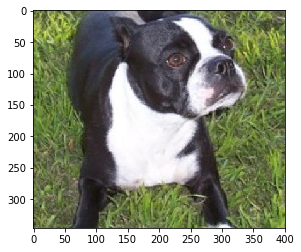

cool!
Hello fellow, your features have the most in common with the English_toy_spaniel dog breed.


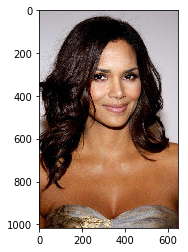

cool!
Sup doggg, I know who you are. You are a .....Kerry_blue_terrier


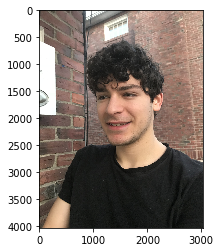

cool!
Hello fellow, your features have the most in common with the Havanese dog breed.


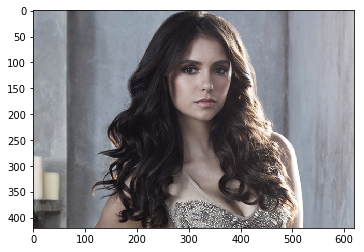

cool!
Sup doggg, I know who you are. You are a .....Pomeranian


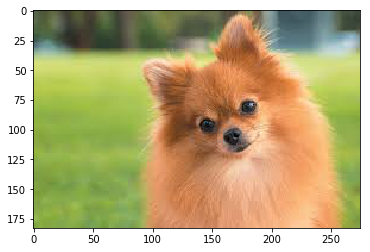

cool!
Sup doggg, I know who you are. You are a .....Afghan_hound


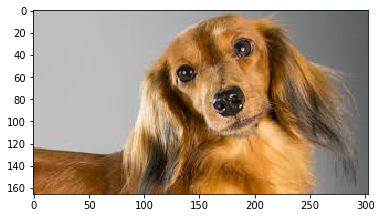

cool!
Hello fellow, your features have the most in common with the Chinese_crested dog breed.


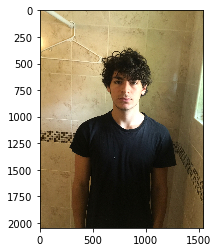

cool!
Sup doggg, I know who you are. You are a .....Labrador_retriever


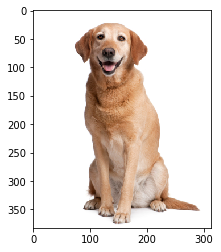

cool!


In [12]:
### EXAMPLE OUTPUTS ###

print(Dog_project('images/testdog.jpg'))
print(Dog_project('images/testhuman.jpg'))
print(Dog_project('images/me.jpg'))
print(Dog_project('images/nina-dobrev.jpg'))
print(Dog_project('images/testdog2.jpeg'))
print(Dog_project('images/testdog3.jpeg'))
print(Dog_project('images/me2.JPG'))
print(Dog_project('images/testdog4.jpg'))


Sup doggg, I know who you are. You are a .....Alaskan_malamute


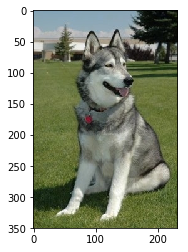

'cool!'

In [13]:
Dog_project('images/alaskan_malamute.JPG')

Sup doggg, I know who you are. You are a .....Labrador_retriever


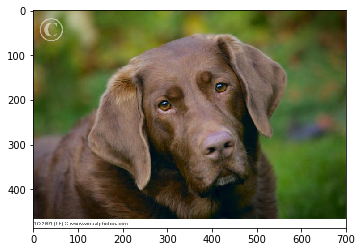

'cool!'

In [14]:
Dog_project('images/Labrador_retriever_06455.jpg')